## 자기 상관(AutoCorrelation)이 강한 시계열 데이터 학습하기
- https://today-1.tistory.com/56?category=886697 를 참고하였습니다.
- https://alpaca-gt.tistory.com/313 에 정리

#### 1. library & data load

In [1]:
# 예제로 사용할 주식 데이터 가져오기
!pip install finance-datareader

In [16]:
import numpy as np

In [4]:
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

start_date = '20210101'
end_date = '20211231'
sample_code = '005930' # 삼성전자
stock = fdr.DataReader(sample_code, start = start_date, end = end_date)

In [5]:
stock

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516
2021-01-08,83300,90000,83000,88800,59013307,0.071170
...,...,...,...,...,...,...
2021-12-24,80200,80800,80200,80500,12086380,0.007509
2021-12-27,80600,80600,79800,80200,10783368,-0.003727
2021-12-28,80200,80400,79700,80300,18226325,0.001247


<AxesSubplot:xlabel='Date'>

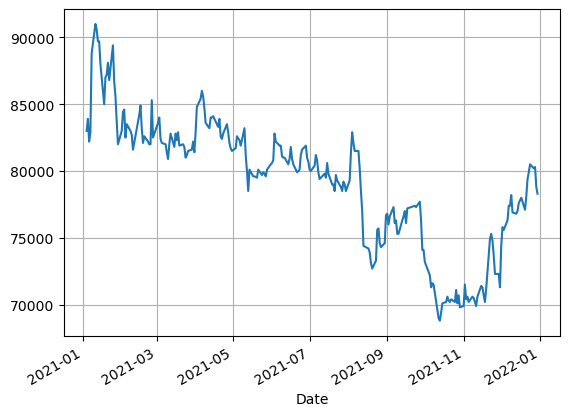

In [6]:
stock.Close.plot(grid=True)

#### 2. 잡음 제거 (Denoising)

- (1) 단순 이동평균 (Simple Moving Average)
    + 구현 및 적용이 용이하나 적절한 파라미터 설정과 값이 우측으로 지연되는 특성

In [7]:
def SMA(df, col, window=2):
    return df[col].rolling(window=window, min_periods=1).mean()

stock['MA(5)'] = SMA(stock, 'Close', 5)

<AxesSubplot:xlabel='Date'>

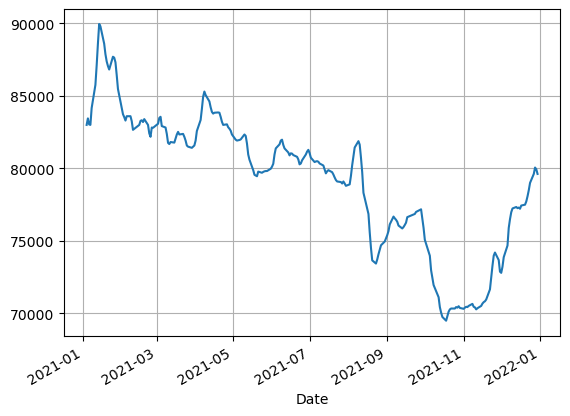

In [8]:
stock['MA(5)'].plot(grid=True)

<AxesSubplot:xlabel='Date'>

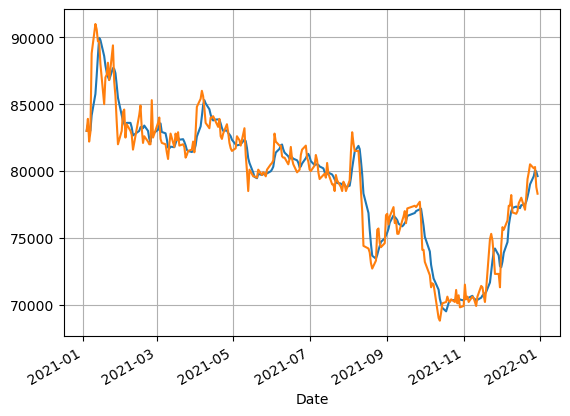

In [12]:
stock['MA(5)'].plot(grid=True)
stock.Close.plot(grid=True)

- (2) 지수 이동평균 (Exponetial Moving Average)
    - 최근값에 가중치를 주며 이동평균을 계산
    - 평활 계수(EP = 2/(기간+1) 를 사용하여 지수이동평균을 계산
    - 지수이동평균 =  (종가(t) x EP) + (지수 이동평균(t-1) x (1-EP))

In [13]:
def EMA(df, col, span=2):
    return df[col].ewm(span=span).mean()

stock['EMA(5)'] = EMA(stock, 'Close', 5)

<AxesSubplot:xlabel='Date'>

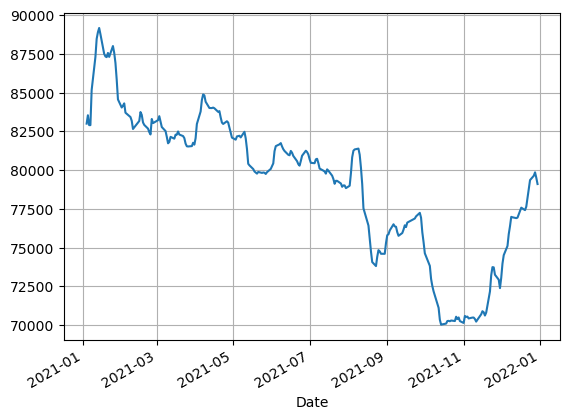

In [14]:
stock['EMA(5)'].plot(grid=True)

<AxesSubplot:xlabel='Date'>

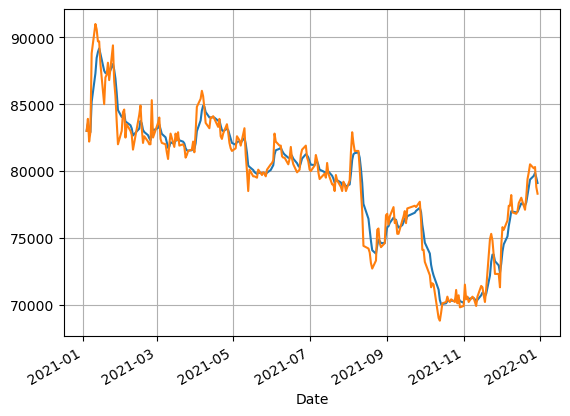

In [15]:
stock['EMA(5)'].plot(grid=True)
stock.Close.plot(grid=True)

- (3) 푸리에 변환(Fourier Transform)
    - 어떤 복잡한 파동이라도 진동수와 진폭이 다른 간단한 파동들의 합으로 나타낼 수 있다
    - 시간 차원에서 발생한 데이터를 주파수 차원으로 변환하여 특정 상위 파동들의 합을 계산하고 다시 시간 차원으로 변환 => 잡음을 제거하여 올바른 신호를 포착

In [17]:
def FFT(df, col, topn=2):
    fft = np.fft.fft(df[col])
    fft[topn:-topn] = 0
    ifft = np.fft.ifft(fft)
    return ifft

stock['FFT(30)'] = FFT(stock, 'Close', 30)

/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<AxesSubplot:xlabel='Date'>

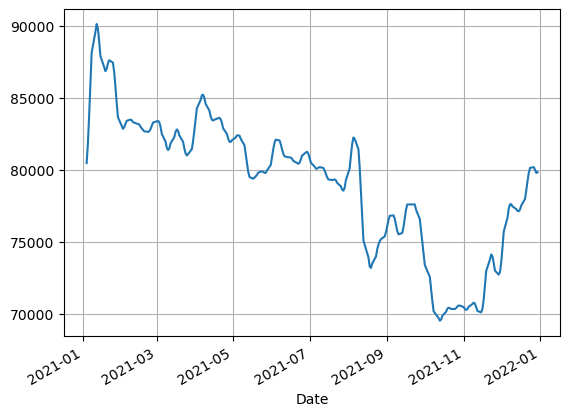

In [21]:
stock['FFT(30)'] .plot(grid=True)

/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<AxesSubplot:xlabel='Date'>

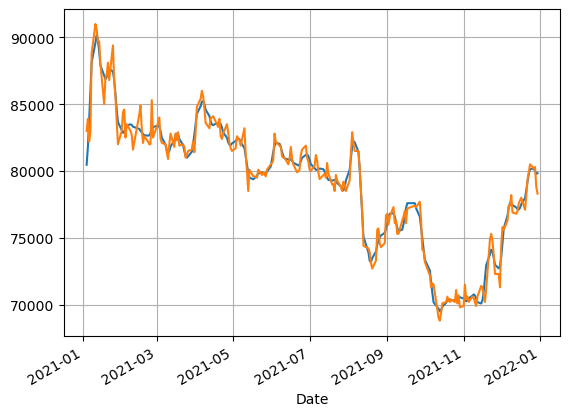

In [22]:
stock['FFT(30)'] .plot(grid=True)
stock.Close.plot(grid=True)

- (4) 웨이블릿 변환(Wavelet Transform)
    - 푸리에 변환의 단점을 해소하고자 개발
    - 고주파 성분 신호에 대해서는 주파수 해상도를 높이고 시간 해상도를 낮춤
    - 저주파 성분 신호에 대해서는 주파수 해상도를 낮추고 시간 해상도를 높이는 웨이블릿 함수를 사용
        - 웨이블릿 변환은 시간의 확장과 축소하는 Scaling과 시간 축으로 이동되는 Shifting이 핵심
        - 동일한 자료를 분석하더라도 모 웨이블릿의 선택에 따라 결과가 달라지기 때문에 데이터 특성에 맞는 모 웨이블릿을 잘 선택
        - 이산 웨이블릿 변환을 위해 Haar, Daubechies 등을 많이 사용

In [27]:
!pip install PyWavelets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 10.9 MB/s eta 0:00:0000:0100:01


In [29]:
import pywt

In [33]:
def WT(df, col, wavelet='db5', thresh=0.63):
    signal = df[col].values
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

stock['db5'] = WT(stock, 'Close')    

<AxesSubplot:xlabel='Date'>

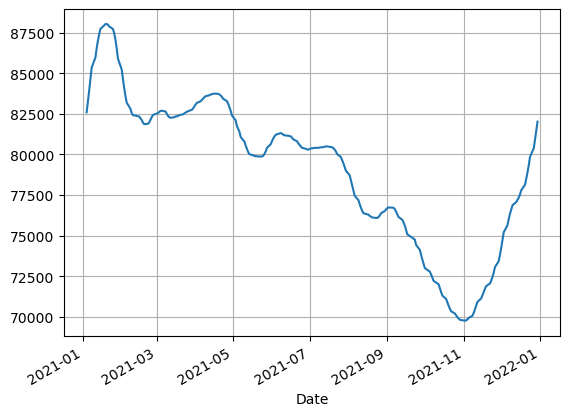

In [34]:
stock['db5'].plot(grid=True)

<AxesSubplot:xlabel='Date'>

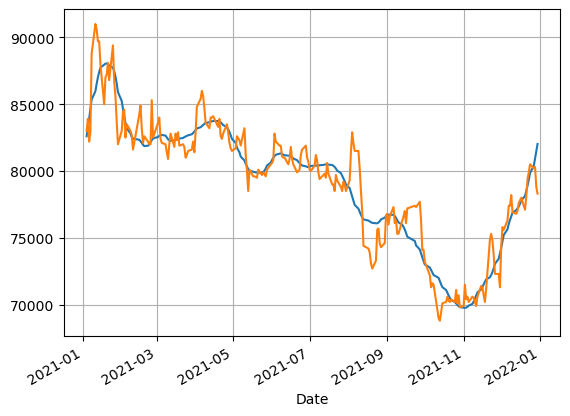

In [35]:
stock['db5'].plot(grid=True)
stock.Close.plot(grid=True)

- (5) AutoEncoder
    - 종단 간(end-to-end) 딥러닝 모델로 잡음을 제거할 수 있는 응용모델(AutoEncoder,.. etc)을 예측 모델과 연결시켜 학습을 진행한다면 학습 비용을 감소시키면서 효과적으로 성능을 향상

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils 

class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        x_reshape = x.contiguous().view(-1, x.size(-1)) 
        y = self.module(x_reshape)
        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))
        return y

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.LSTM(
                               input_size = 1, 
                               hidden_size = 16, 
                               dropout = 0.25,
                               num_layers = 2,
                               bias = True,
                               batch_first = True,
                               bidirectional = True,
                               )
        self.decoder = nn.LSTM(
                               input_size = 32, 
                               hidden_size = 16, 
                               dropout = 0.25,
                               num_layers = 2,
                               bias = True,
                               batch_first = True,
                               bidirectional = True,
                               )
        self.fc = TimeDistributed(nn.Linear(32, 1))
                
    def forward(self, x):
        h0, (h_n, c_n) = self.encoder(x)
        h0, (h_n, c_n) = self.decoder(h0[:,-1:,:].repeat(1,5,1))
        out = self.fc(h0)
        return out

#### 3. 시각화
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fxefbn%2FbtrNcWKMxx5%2FeF5cyYiNgAK1vM5cKtRLgK%2Fimg.png">

- 단순 이동평균(MA)과 지수 이동평균(EMA)은 기존 데이터에 비해 스무딩 된 표현을 얻음
    - 여전히 큰 분산을 보이고 있음
- 푸리에 변환(FFT)을 살펴보면 기존 방법들에 비해 더 부드러운 표현을 가지게 되었고 많은 잡음이 제거
- 웨이블릿 변환(WT)은 푸리에 변환보다 더 부드러운 파동의 형태를 지니게 되어 기존 잡음과 더불어 정보까지 같이 손실
- 오토 인코더(AE)의 경우 기존 데이터와 푸리에 변환 중간쯤의 표현력을 지님

#### 4. 결과

1. 푸리에 변환(FFT)이 가장 좋은 성능
2. 오토 인코더(AE) 모델이 잡음 제거로 인해 좋은 성능
3. 이동평균(MA, EMA) 방법들은 과거의 결과 자료로써 데이터를 재구성하는 방법이기 때문에 후행 예측이 여전히 존재 (검증 데이터의 학습이 제대로 진행되지 않음)
4. 웨이블릿 변환(WT)의 경우 후행 예측 문제를 해소할 수 있으나 변환 작업에서 신호의 잡음과 정보를 같이 손실되어 정확도를 잃게됨